In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import tensorflow as tf
from scipy.io import wavfile as wav
import warnings
warnings.filterwarnings('ignore')

In [32]:
audio_dataset_path='sound_split/sounds/'
metadata=pd.read_csv('sound_split/Splitmetadata.csv')
mfcc = 70 # öznitelik sayısı
num_labels = 7 # Sınıf sayısı
unique_class = metadata['class_name'].unique()

In [3]:
def features_extractor(filename):
    
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [4]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["file_name"]))
    final_class_labels=row["class_name"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

5178it [07:39, 11.28it/s]


In [55]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])

X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [82]:
model=Sequential()
# 1. hidden layer
model.add(Dense(100,input_shape=(mfcc,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# 2. hidden layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# 3. hidden layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy',f1_m, precision_m, recall_m], optimizer='adam')

In [91]:
epochscount = 40
num_batch_size = 32

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)

Epoch 1/40
130/130 [==============================] - 1s 11ms/step - loss: 0.0410 - accuracy: 0.9872 - f1_m: 0.9869 - precision_m: 0.9882 - recall_m: 0.9856 - val_loss: 0.0782 - val_accuracy: 0.9875 - val_f1_m: 0.9872 - val_precision_m: 0.9896 - val_recall_m: 0.9848
Epoch 2/40
130/130 [==============================] - 1s 11ms/step - loss: 0.0432 - accuracy: 0.9870 - f1_m: 0.9872 - precision_m: 0.9894 - recall_m: 0.9851 - val_loss: 0.0926 - val_accuracy: 0.9768 - val_f1_m: 0.9790 - val_precision_m: 0.9838 - val_recall_m: 0.9744
Epoch 3/40
130/130 [==============================] - 1s 11ms/step - loss: 0.0384 - accuracy: 0.9867 - f1_m: 0.9866 - precision_m: 0.9882 - recall_m: 0.9851 - val_loss: 0.1016 - val_accuracy: 0.9797 - val_f1_m: 0.9805 - val_precision_m: 0.9829 - val_recall_m: 0.9782
Epoch 4/40
130/130 [==============================] - 1s 10ms/step - loss: 0.0354 - accuracy: 0.9894 - f1_m: 0.9894 - precision_m: 0.9910 - recall_m: 0.9879 - val_loss: 0.1005 - val_accuracy: 0.9817 

In [88]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print("Acc : ",validation_test_set_accuracy[1])
print("Loss : ",validation_test_set_accuracy[0])

Acc :  0.9768339395523071
Loss :  0.09489042311906815


In [89]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


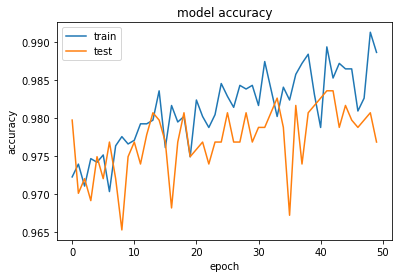

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('c.png')

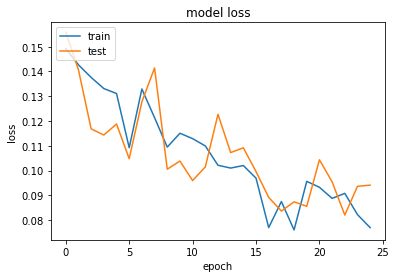

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
print("F1-skor : ",history.history['f1_m'][-1])
print("Precision skor : ",history.history['precision_m'][-1])
print("Recall skor : ",history.history['recall_m'][-1])

F1-skor :  0.9751057624816895
Precision skor :  0.9792178869247437
Recall skor :  0.9711538553237915


In [77]:
y_pred = model.predict(X_test)

2022-05-29 21:53:41.203489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [78]:
predict_y, test_y =[],[]
for a in y_pred:
    predict_y.append(np.argmax(a))
for i in y_test:
    test_y.append(np.argmax(i))
print(len(predict_y))
print(len(test_y))

1036
1036


In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, predict_y)

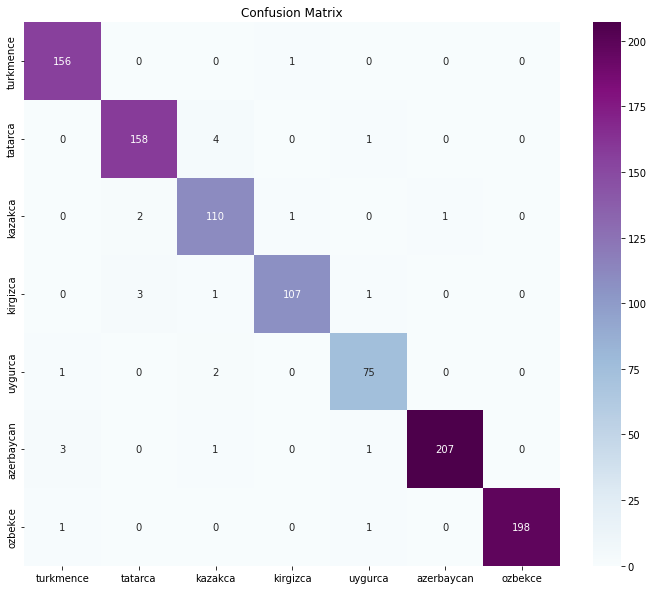

In [80]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in unique_class],
                  columns = [i for i in unique_class])
plt.figure(figsize = (12,10))
plt.title("Confusion Matrix")
ss = sn.heatmap(df_cm, annot=True,fmt="d", cmap="BuPu")
figure = ss.get_figure()    
#figure.savefig('cnn_conf.png', dpi=400)

In [ ]:
from sklearn.metrics import classification_report
a = classification_report(test_y,predict_y,output_dict=True)
df_prf = pd.DataFrame(a).transpose()

df_class_prf = pd.DataFrame(df_prf, index = ['0','1','2','3','4','5','6'],
                  columns = ['precision','recall','f1-score'])
df_prf


,precision,recall,f1-score,support
0,0.980892,0.980892,0.980892,157.000000
1,0.969512,0.975460,0.972477,163.000000
2,0.948718,0.973684,0.961039,114.000000
3,0.981818,0.964286,0.972973,112.000000
4,0.961039,0.948718,0.954839,78.000000
5,0.990521,0.985849,0.988180,212.000000
6,0.995000,0.995000,0.995000,200.000000
accuracy,0.978764,0.978764,0.978764,0.978764
macro avg,0.975357,0.974841,0.975057,1036.000000
weighted avg,0.978861,0.978764,0.978781,1036.000000
